# 1. Entrada de dados

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats
import seaborn as sns
from datetime import date, datetime

from sklearn.neighbors import LocalOutlierFactor
# from sklearn.datasets import make_blobs
from numpy import quantile, where, random

import warnings
warnings.filterwarnings('ignore')
from glob import glob

In [42]:
# Carregar as funções:
%run "./calc_eto.ipynb"
#%run "./DP_find_extreme_values.ipynb"
#%run "./IQR_find_extreme_values.ipynb"
%run "./data_distribution.ipynb"

In [43]:
pd.set_option('float_format', '{:.2f}'.format)
#pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 30)

* Estações do INMET: 

    1- Paraná - TO (A010); 

    2- Imperatriz - MA (A225);

    3- Bom Jesus do Piauí - PI (A326);

    4- Luíz Eduardo Magalhães - BA (A404);

    5- Casa Branca - SP (A738).

* Variáveis climáticas:
    Data: De 01/01/2008 à 31/12/2022 (15 anos);

    Tmax: Em graus Celsius (ºC);

    Tmin: Em graus Celsius (ºC);

    URmax: Umidade relativa (%);

    URmin: Umidade relativa (%);

    u: Velocidade do vento em metros por segundo (m/s), medido a 10 metros de altura;
    
    Rad: Radiação solar global em Kilojoules por hora (KJ/h).

In [44]:
# 1) Paraná - TO (A010)
df_A010 = pd.read_csv('./Dados_Estacoes/A010.csv', sep = ';')
df_A010.head(3) # primeiras linhas
# df_A010.tail(3) # últimas linhas
# df_A010 # todo o dataframe

,Data,Hora,Prec,Rad,Tmax,Tmin,Urmax,Urmin,u
0,2008-01-01,0,0.00,-3.54,27.00,26.10,79.00,74.00,1.80
1,2008-01-01,100,0.00,-3539.00,26.40,25.50,82.00,78.00,1.60
2,2008-01-01,200,0.00,-3.54,25.70,25.30,82.00,82.00,1.40


In [45]:
# 2) Imperatriz - MA (A225)
df_A225 = pd.read_csv('./Dados_Estacoes/A225.csv', sep = ';')
df_A225.head(3) # primeiras linhas
# df_A225.tail(3) # últimas linhas
# df_A225 # todo o dataframe

,Data,Hora,Prec,Rad,Tmax,Tmin,Urmax,Urmin,u
0,2008-02-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-02-29,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-02-29,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# 3) Bom Jesus do Piauí - PI (A326)
df_A326 = pd.read_csv('./Dados_Estacoes/A326.csv', sep = ';')
df_A326.head(3) # primeiras linhas
# df_A326.tail(3) # últimas linhas
# df_A326 # todo o dataframe

,Data,Hora,Prec,Rad,Tmax,Tmin,Urmax,Urmin,u
0,2008-01-01,0,0.00,-3.54,29.00,27.80,54.00,45.00,0.20
1,2008-01-01,100,0.00,-3536.00,28.30,26.10,64.00,50.00,1.10
2,2008-01-01,200,0.00,-3538.00,27.20,26.70,65.00,59.00,0.00


In [47]:
# 4) Luíz Eduardo Magalhães - BA (A404)
df_A404 = pd.read_csv('./Dados_Estacoes/A404.csv', sep = ';')
df_A404.head(3) # primeiras linhas
# df_A404.tail(3) # últimas linhas
# df_A404 # todo o dataframe

,Data,Hora,Prec,Rad,Tmax,Tmin,Urmax,Urmin,u
0,2008-01-01,0,NaN,-3539.00,24.30,23.60,60.00,55.00,3.00
1,2008-01-01,100,NaN,-3526.00,24.50,23.50,62.00,53.00,2.20
2,2008-01-01,200,NaN,-877.00,25.70,23.70,64.00,51.00,0.00


In [48]:
# 5) Casa Branca - SP (A738)
df_A738 = pd.read_csv('./Dados_Estacoes/A738.csv', sep = ';')
df_A738.head(3) # primeiras linhas
# df_A738.tail(3) # últimas linhas
# df_A738 # todo o dataframe

,Data,Hora,Prec,Rad,Tmax,Tmin,Urmax,Urmin,u
0,2008-01-01,0,0.00,-1.45,27.90,27.30,53.00,50.00,1.80
1,2008-01-01,100,0.00,-3.54,27.30,26.40,57.00,53.00,0.20
2,2008-01-01,200,0.00,-3.54,26.90,25.90,62.00,56.00,0.80


# 2. Calcular a $ET_{0}$: dados brutos

In [49]:
# 1) Paraná - TO (A010)
df_estacao = pd.read_csv('./Dados_Estacoes/A010.csv', sep = ';')
df_estacao

,Data,Hora,Prec,Rad,Tmax,Tmin,Urmax,Urmin,u
0,2008-01-01,0,0.00,-3.54,27.00,26.10,79.00,74.00,1.80
1,2008-01-01,100,0.00,-3539.00,26.40,25.50,82.00,78.00,1.60
2,2008-01-01,200,0.00,-3.54,25.70,25.30,82.00,82.00,1.40
3,2008-01-01,300,0.00,-3.54,25.40,25.20,83.00,82.00,1.30
4,2008-01-01,400,0.00,-3.54,25.30,24.80,84.00,82.00,0.60
...,...,...,...,...,...,...,...,...,...
131491,2022-12-31,1900,NaN,1748724.00,31.80,30.40,58.00,53.00,1.30
131492,2022-12-31,2000,NaN,1766882.00,31.20,30.00,59.00,52.00,2.00
131493,2022-12-31,2100,NaN,935658.00,30.60,29.10,59.00,54.00,1.60
131494,2022-12-31,2200,NaN,101518.00,29.10,27.20,67.00,58.00,1.30


In [50]:
# Chamar a função para calcular a ETo:
# def calc_eto(df_estacao, alt, lat)
alt = 284
lat = -12.615

df_estacao = calc_eto(df_estacao, alt, lat)
df_estacao

,Data,Dia_Ano,Hora,Prec,Rad,Tmax,Tmed,Tmin,Urmax,Urmed,Urmin,u,Anos,Meses,P,...,ea,Delta,dr,delta,phi,omega_s,Ra,Rso,a,b,c,Rnl,Rns,Rn,ETo
0,2008-01-01,1,0,0.00,-3.54,27.00,26.55,26.10,79.00,76.50,74.00,1.80,2008,Jan,97.99,...,2.66,0.20,1.03,-0.40,-0.22,1.67,40.24,30.41,8068834523.47,0.11,-0.51,-2.24,-2.73,-0.48,-0.01
1,2008-01-01,1,100,0.00,-3539.00,26.40,25.95,25.50,82.00,80.00,78.00,1.60,2008,Jan,97.99,...,2.68,0.20,1.03,-0.40,-0.22,1.67,40.24,30.41,8004415590.86,0.11,-157.47,-684.26,-2725.03,-2040.77,-81.06
2,2008-01-01,1,200,0.00,-3.54,25.70,25.50,25.30,82.00,82.00,82.00,1.40,2008,Jan,97.99,...,2.68,0.19,1.03,-0.40,-0.22,1.67,40.24,30.41,7956268147.37,0.11,-0.51,-2.20,-2.73,-0.53,-0.02
3,2008-01-01,1,300,0.00,-3.54,25.40,25.30,25.20,83.00,82.50,82.00,1.30,2008,Jan,97.99,...,2.66,0.19,1.03,-0.40,-0.22,1.67,40.24,30.41,7934961631.61,0.11,-0.51,-2.20,-2.73,-0.52,-0.02
4,2008-01-01,1,400,0.00,-3.54,25.30,25.05,24.80,84.00,83.00,82.00,0.60,2008,Jan,97.99,...,2.64,0.19,1.03,-0.40,-0.22,1.67,40.24,30.41,7908436690.31,0.11,-0.51,-2.22,-2.73,-0.51,-0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131491,2022-12-31,365,1900,NaN,1748724.00,31.80,31.10,30.40,58.00,55.50,53.00,1.30,2022,Dez,97.99,...,2.51,0.26,1.03,-0.40,-0.22,1.67,40.24,30.41,8570244972.10,0.12,77639.87,385706.63,1346517.48,960810.85,64929.29
131492,2022-12-31,365,2000,NaN,1766882.00,31.20,30.60,30.00,59.00,55.50,52.00,2.00,2022,Dez,97.99,...,2.44,0.25,1.03,-0.40,-0.22,1.67,40.24,30.41,8513977596.35,0.12,78446.05,397491.48,1360499.14,963007.66,63743.98
131493,2022-12-31,365,2100,NaN,935658.00,30.60,29.85,29.10,59.00,56.50,54.00,1.60,2022,Dez,97.99,...,2.38,0.24,1.03,-0.40,-0.22,1.67,40.24,30.41,8430315137.31,0.12,41541.19,213048.14,720456.66,507408.52,32086.55
131494,2022-12-31,365,2200,NaN,101518.00,29.10,28.15,27.20,67.00,62.50,58.00,1.30,2022,Dez,97.99,...,2.39,0.22,1.03,-0.40,-0.22,1.67,40.24,30.41,8242901010.95,0.12,4506.87,22537.00,78168.86,55631.86,3011.14


In [51]:
# Estatística dos dados:
# 25%: 1º quartil
# 50%: 2º quartil (mediana)
# 75%: 3º quartil
df_estacao[['Prec','Rad','Tmax','Tmed','Tmin','Urmax','Urmed','Urmin','u',]].describe().T

,count,mean,std,min,25%,50%,75%,max
Prec,109745.00,0.12,1.23,0.00,0.00,0.00,0.00,56.80
Rad,118685.00,735202.98,1085178.84,-7079.00,-3.60,1884.47,1443748.00,4826139.00
Tmax,118783.00,26.85,5.24,12.40,22.90,26.00,31.20,42.00
Tmed,118783.00,26.08,5.04,11.65,22.50,25.15,30.05,40.60
Tmin,118784.00,25.31,4.90,10.90,22.10,24.40,29.00,40.00
Urmax,118784.00,67.11,22.61,9.00,51.00,74.00,87.00,96.00
Urmed,118749.00,63.87,22.93,8.50,46.00,69.00,84.50,96.00
Urmin,118749.00,60.62,23.57,8.00,41.00,64.00,83.00,96.00
u,118829.00,1.01,1.14,0.00,0.00,0.60,1.70,10.10


In [52]:
# Percentual de ausentes em ordem decrescente:
(df_estacao.isna().sum() / df_estacao.shape[0] * 100).sort_values(ascending=False)

Prec      16.54
ETo        9.85
Rn         9.84
Rnl        9.84
Rad        9.74
Rns        9.74
c          9.74
b          9.69
ea         9.69
Urmed      9.69
Urmin      9.69
es_tmed    9.67
a          9.67
Delta      9.67
es         9.67
es_tmax    9.67
Tmax       9.67
Tmed       9.67
es_tmin    9.67
Tmin       9.67
Urmax      9.67
u          9.63
Ra         0.00
Hora       0.00
Rso        0.00
omega_s    0.00
Dia_Ano    0.00
phi        0.00
delta      0.00
dr         0.00
Anos       0.00
Meses      0.00
P          0.00
gamma      0.00
Data       0.00
dtype: float64

In [53]:
# Estatística descritiva: Histogramas x Gráfico Quantil x Boxplot
# Medir o grau de simetria da curva, em relação a distribuição normal:
# Se skew = 0 -> distribuição simétrica;
# Se skew > 0 -> assimétrica positiva (à direita);
# Se skew < 0 -> assimétrica negativa (à esquerda).

print('Tmax:', df_estacao['Tmax'].skew())
print('Tmin:', df_estacao['Tmin'].skew())
print('Urmed:', df_estacao['Urmed'].skew())
print('u:', df_estacao['u'].skew())
print('Rad:', df_estacao['Rad'].skew())
print('ETo:', df_estacao['ETo'].skew())

Tmax: 0.2039749260357977
Tmin: 0.22426325339992614
Urmed: -0.5231693012231704
u: 1.1892172919823327
Rad: 1.2059450707638781
ETo: 1.74499111634628


In [54]:
# Medir o grau de achatamento da curva, em relação a curva normal:
# Se kurtosis = 0 -> distribuição mesocúrtica (normal);
# Se kurtosis > 0 -> distribuição leptocúrtica, correspondendo a uma curva mais pontuda;
# Se kurtosis < 0 -> platicúrtica, ou seja, uma curva mais achatada, com maior variabilidade dos dados.

print('Tmax:', df_estacao['Tmax'].kurtosis())
print('Tmin:', df_estacao['Tmin'].kurtosis())
print('Urmed:', df_estacao['Urmed'].kurtosis())
print('u:', df_estacao['u'].kurtosis())
print('Rad:', df_estacao['Rad'].kurtosis())
print('ETo:', df_estacao['ETo'].kurtosis())

Tmax: -0.6935952989179972
Tmin: -0.41431504163169475
Urmed: -0.9477143022981811
u: 1.1526616064649993
Rad: 0.007243879084021909
ETo: 2.311678431073344


NameError: name 'sns' is not defined

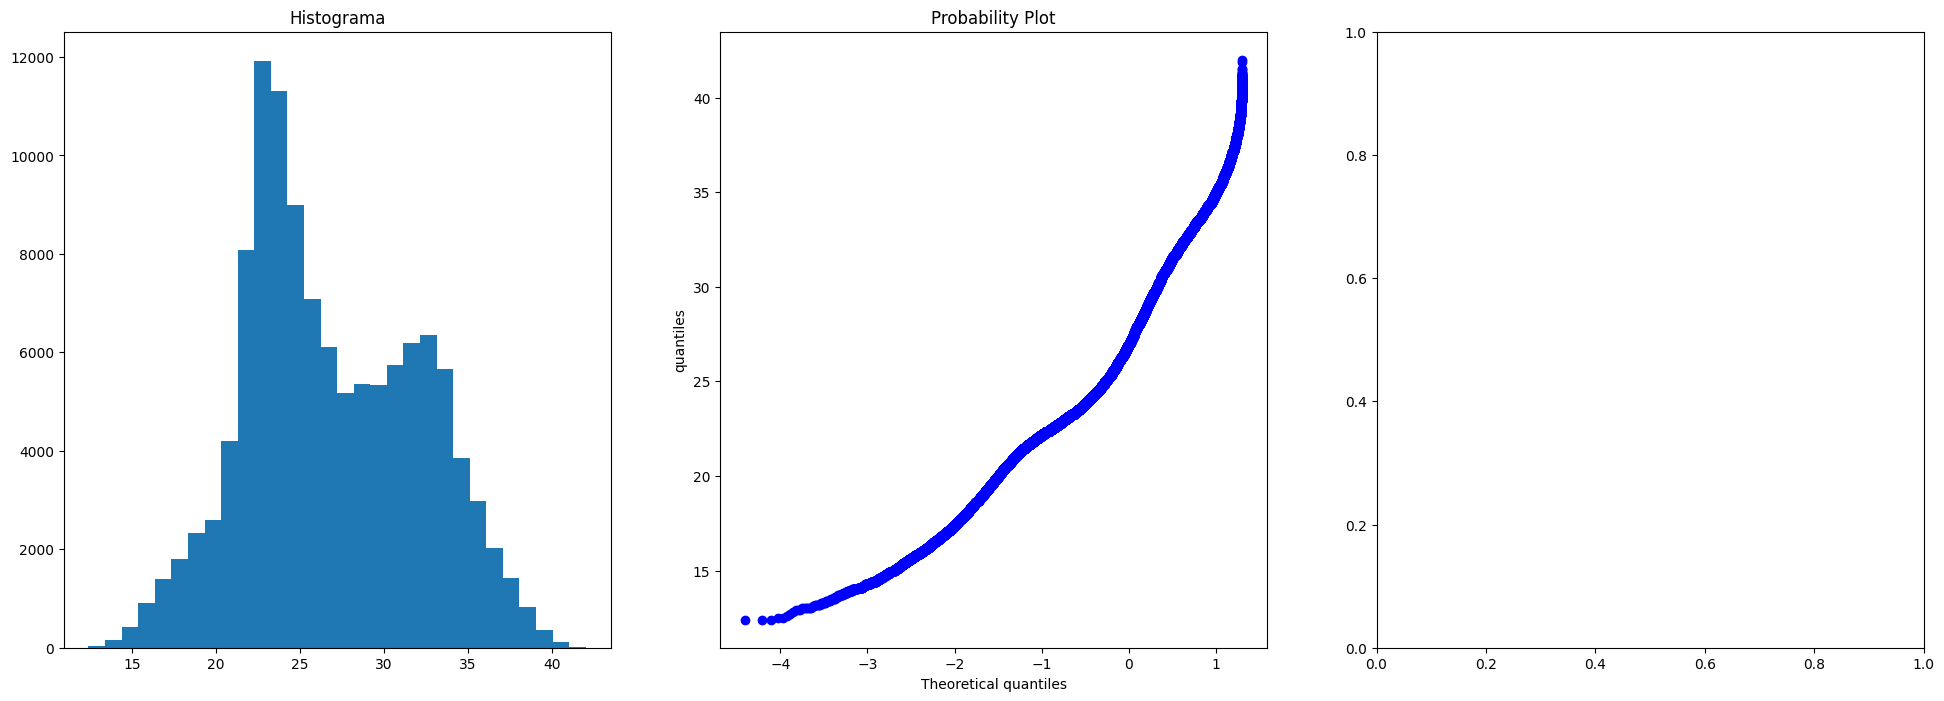

In [55]:
# Plotar os gráficos:
data_distribution(df_estacao,'Tmax')
data_distribution(df_estacao,'Tmin')
data_distribution(df_estacao,'Urmed')
data_distribution(df_estacao,'u')
data_distribution(df_estacao,'Rad')
data_distribution(df_estacao,'ETo')

# 3. Medidas descritivas dos dados

In [ ]:
#### Conhecendo os dados ####

# full_files.info()
# full_files.shape # linhas x colunas (1.969.488, 9)
# type(full_files) # tipo de dado
# full_files.index # (start=0, stop=1.969.488, step=1)
# full_files.columns # nome das colunas

In [ ]:
#### Verificar dados ausentes (quantidade absoluta) ####

# False = 0
# True = 1
# full_files.isna().sum()

In [ ]:
#### Se retornar "True", tem valor ausente ####

# full_files.isna().any()

In [ ]:
#### Percentual de ausentes em ordem decrescente ####

# (full_files.isna().sum() / full_files.shape[0] * 100).sort_values(ascending=False)

In [ ]:
#### Quantidade de valores únicos por coluna ####

# Ex.: Hora = 24, pois temos 24h
# full_files.nunique().sort_values(ascending=True)

In [ ]:
#### Estatística dos dados ####

# 25%: 1º quartil
# 50%: 2º quartil (mediana)
# 75%: 3º quartil
# full_files.describe().transpose()

In [ ]:
# https://medium.com/geekculture/create-an-advanced-gantt-chart-in-python-f2608a1fd6cc 

# 4. Pré-processamento (Limpeza dos dados)

In [ ]:
# full_files.head(3) # primeiras linhas
# full_files.tail(3) # últimas linhas

In [ ]:
#full_files['Data'] = pd.to_datetime(full_files['Data'], format='%Y-%m-%d').dt.strftime('%d/%m/%Y')
#full_files.head(3)

# 5. Método de aprendizado de máquina: Local Outlier Finder